# Project Steps
 ## Main Steps:

* Camera calibration and distortion correction.
* Color/gradient threshold.
* Perspective transform.
* Detect lane lines.

## Extra Step:
* Determine the lane curvature.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
import os
test_dir = "test_images"
test_files = os.listdir(test_dir)
test_files

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

# Camera Calibration  and Distortion Correction


*   Utils


In [3]:
def cameraCalibrate(image):
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    import glob

    #read in and make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    #Arrays to store objects points and image points from all the images
    objpoints = [] #3d points
    imgpoints = [] #2d points

    #prepare points
    objp  = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


    for fname in images:
        #read in each image
        img = mpimg.imread(fname)
        #convert image to gray scale  
        gray  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        #find corners  
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    shape =(img.shape[1],img.shape[0])
    ret, mtx, dist, rvect, tvect = cv2.calibrateCamera(objpoints,imgpoints,shape,None,None)
    
    #undistored the image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

* Apply (Calibrate)

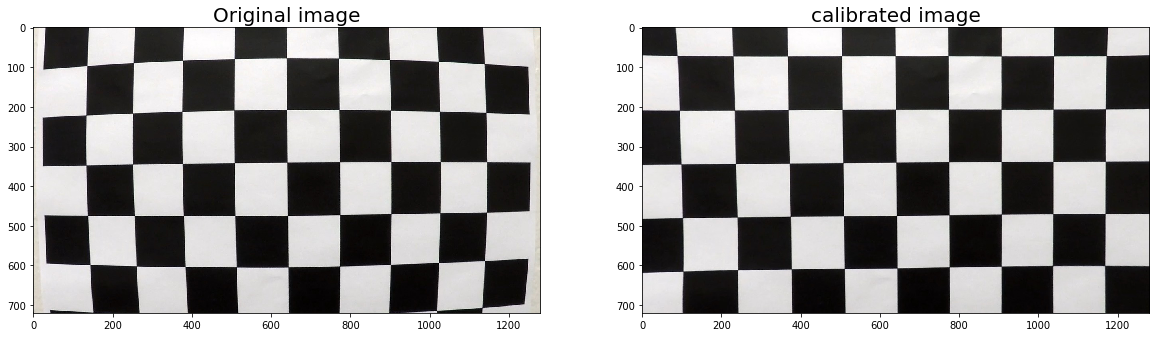

In [4]:
sample_image = mpimg.imread(test_dir + '/test3.jpg')
sample_image = mpimg.imread('./camera_cal/calibration1.jpg')

f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image', fontsize=20)
ax1.imshow(sample_image)
ax2.set_title('calibrated image', fontsize=20)
calibrated_image=cameraCalibrate(sample_image)
ax2.imshow(cameraCalibrate(sample_image))

# Gradient / Color Threshold

* Utils

In [5]:
def visualize(ch1, ch2, ch3,
            ch1_name, ch2_name, ch3_name,
            plot):
    plot[0].set_title(ch1_name + '_channel', fontsize=20)
    plot[0].imshow(ch1,cmap='gray')
    plot[1].set_title(ch2_name + '_channel', fontsize=20)
    plot[1].imshow(ch2,cmap='gray')
    plot[2].set_title(ch3_name + '_channel', fontsize=20)
    plot[2].imshow(ch3,cmap='gray')

def binarize(array, l_thresh, u_thresh, yes=1, no=0):
    binary = (array >= l_thresh) * array
    binary = (array <= u_thresh) * binary
    binary = (binary > 0)*yes
    return binary

# Color threshold for the white line
def white(img, channel_num = 0, white_thresh = (220,255)):
    channel = img[:,:,channel_num]    
    l_thresh, u_thresh = white_thresh[:]
    binary = binarize(channel, l_thresh, u_thresh, yes=255, no=0)
    return binary

# Color threshold for the yellow line
def yellow(img, channel_num = 2, yellow_thresh = (220,255)):
    channel = img[:,:,channel_num]
    l_thresh, u_thresh = yellow_thresh[:]
    # binary = cv2.inRange(img, np.array([220, 220, 220]), np.array([255, 255, 255]))
    binary = binarize(channel, l_thresh, u_thresh, yes=255, no=0)
    return binary

* Possible Models

-- HLS Model

-- HSV Model

-- LAB Model

-- RGB Model

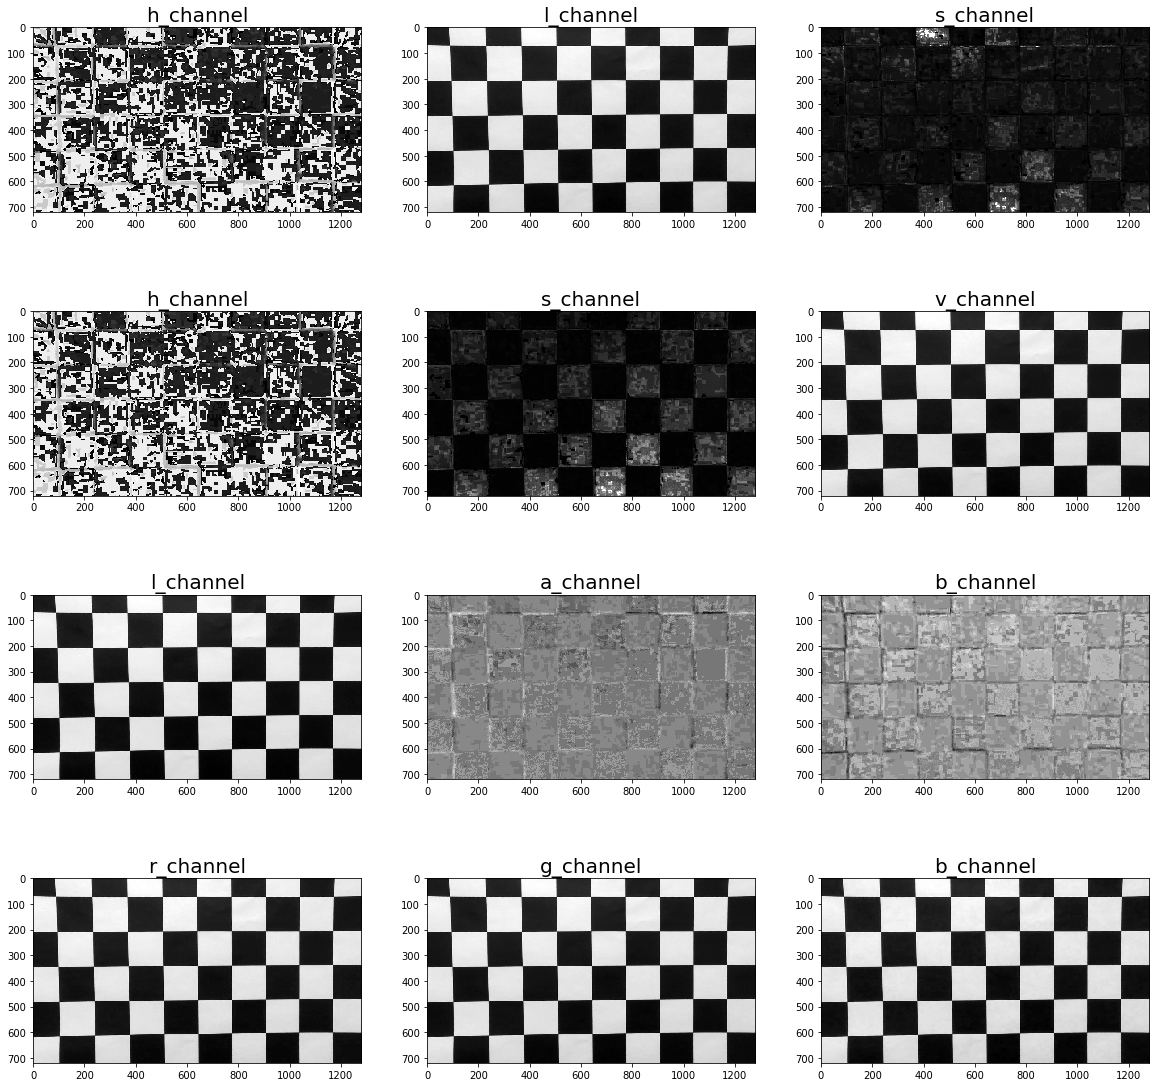

In [6]:
image_in_action = calibrated_image
f, plot_axs = plt.subplots(4, 3, figsize=(20,20))

hls_image = cv2.cvtColor(image_in_action,cv2.COLOR_RGB2HLS)
h_channel = hls_image[:,:,0]
l_channel = hls_image[:,:,1]
s_channel = hls_image[:,:,2]
visualize(h_channel, l_channel, s_channel, "h", "l", "s", plot_axs[0])

hsv_image = cv2.cvtColor(image_in_action,cv2.COLOR_RGB2HSV)
h_channel = hsv_image[:,:,0]
s_channel = hsv_image[:,:,1]
v_channel = hsv_image[:,:,2]
visualize(h_channel, s_channel, v_channel, "h", "s", "v", plot_axs[1])

lab_image = cv2.cvtColor(image_in_action,cv2.COLOR_RGB2LAB)
l_channel = lab_image[:,:,0]
a_channel = lab_image[:,:,1]
b_channel = lab_image[:,:,2]
visualize(l_channel, a_channel, b_channel, "l", "a", "b", plot_axs[2])

rgb_image = image_in_action
r_channel = rgb_image[:,:,0]
g_channel = rgb_image[:,:,1]
b_channel = rgb_image[:,:,2]
visualize(r_channel, g_channel, b_channel, "r", "g", "b", plot_axs[3])

* Apply

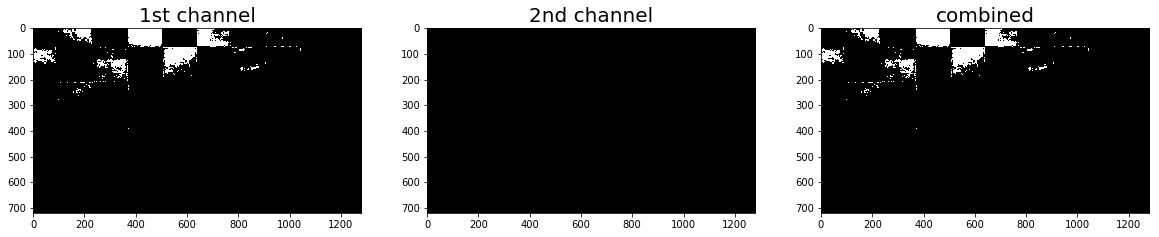

In [7]:
image_in_action = calibrated_image
binary_white = white(image_in_action, channel_num=0, white_thresh = (245,255))
binary_yellow = yellow(lab_image, channel_num=2, yellow_thresh = (170,200))

# combine both the white and yellow binaries in combined_binary
binary_combined = np.zeros_like(image_in_action)
binary_combined[(binary_white >= 1) | (binary_yellow >= 1)] = 255

# visualize
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.set_title('1st channel', fontsize=20)
ax1.imshow(binary_white,cmap='gray')
ax2.set_title('2nd channel', fontsize=20)
ax2.imshow(binary_yellow,cmap='gray')
ax3.set_title('combined', fontsize=20)
ax3.imshow(binary_combined,cmap='gray')

In [8]:
image_in_action = cv2.merge((binary_combined,binary_combined,binary_combined))
# print(np.max(image_in_action))
print(calibrated_image.shape)

(720, 1280, 3)


# Perspective Transform

* Utils

In [9]:
def perspective_transform(undistorted, flag?):   

    
    img = undistorted
    w = image_in_action.shape[1]
    h = image_in_action.shape[0]
    img_size = (w, h)
    src = np.float32([[w/8,h],[3*w/8,4*h/6],
                  [5*w/8,4*h/6],[7*w/8,h]])
    # make sure that the points follow the right arrangement whether it's clockwise or counter-clockwise
    # source and destination points must have the same arrangement whether it's clockwise or counter-clockwise
    # The points in src array are (x,y).
    dst = np.float32([[2*w/10,h],[2*w/10,2*h/10],
                    [8*w/10,2*h/10],[8*w/10,h]])

    if(flag? == 1):
        M = cv2.getPerspectiveTransform(src, dst)
    transformed_img = cv2.warpPerspective(undistorted, M, img_size, flags=cv2.INTER_LINEAR)

    # gray_scale = False

    # if len(img.shape) == 2:
    #     print(img.shape)
    #     gray_scale = True
    #     img = cv2.cvtColor(undistorted, cv2.COLOR_GRAY2RGB)
    # M = cv2.getPerspectiveTransform(src, dst)
    # transformed_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)


    # if gray_scale:
    #     transformed_img = cv2.cvtColor(transformed_img, cv2.COLOR_RGB2GRAY)

    return transformed_img

* Apply (Transform)

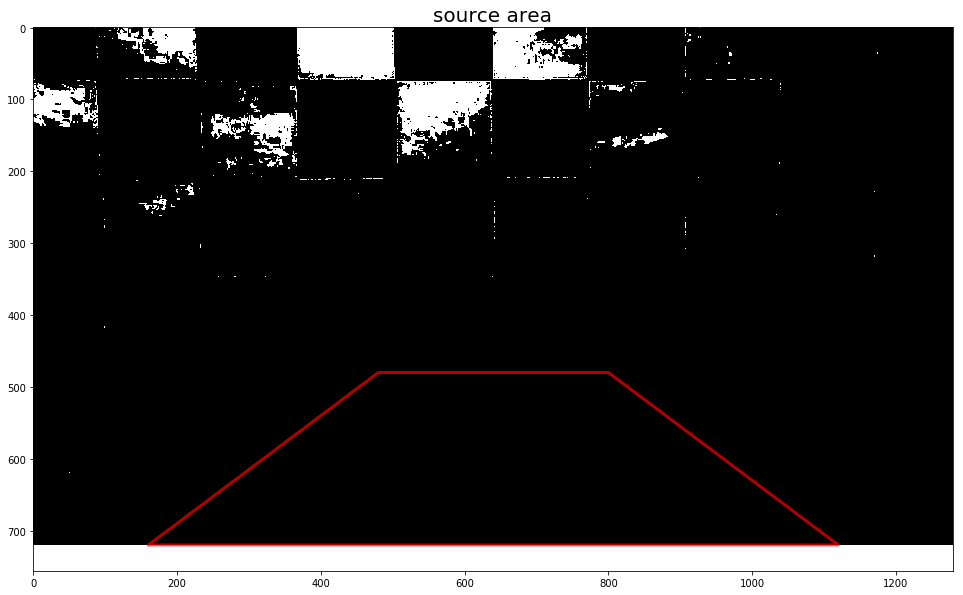

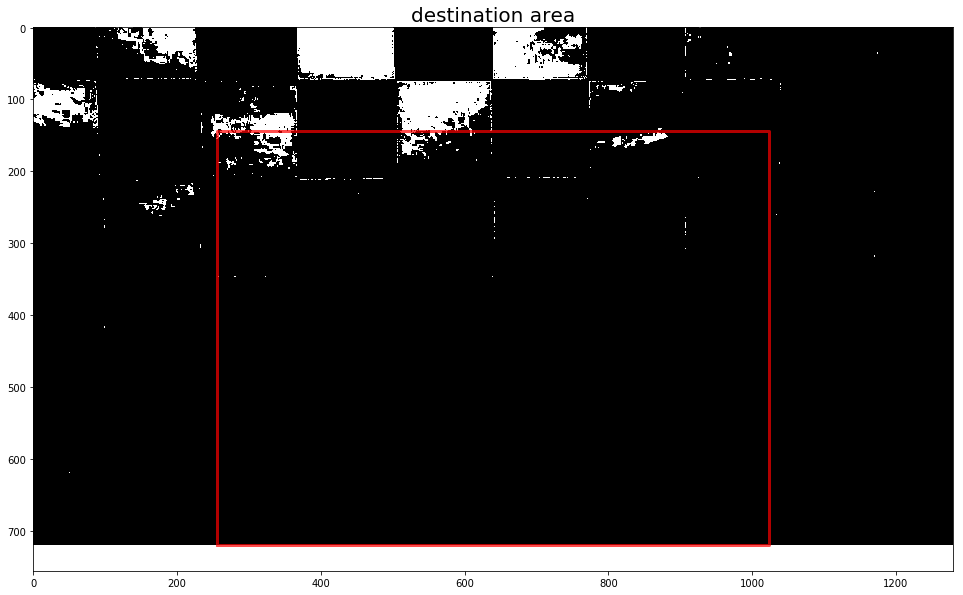

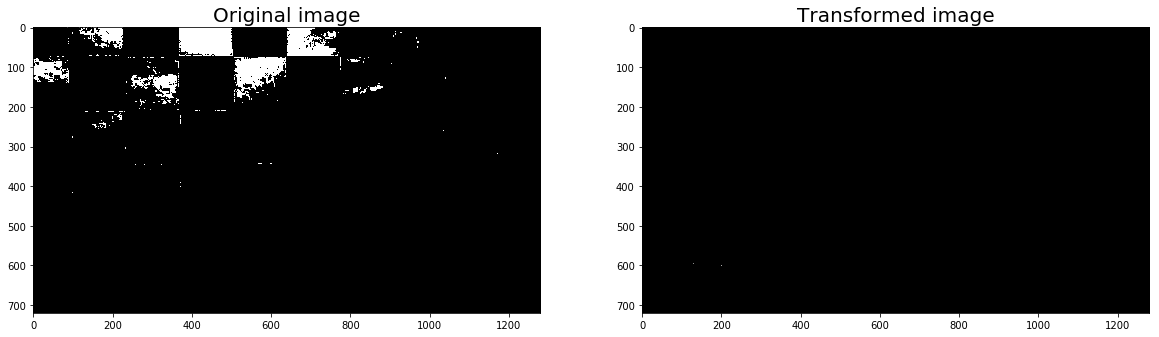

In [10]:
# make sure that the points follow the right arrangement whether it's clockwise or counter-clockwise
# source and destination points must have the same arrangement whether it's clockwise or counter-clockwise
# The points in src array are (x,y).
# task_image = cameraCalibrate(task_image)
image_in_action = binary_combined
# print(image_in_action.shape)
w = image_in_action.shape[1]
h = image_in_action.shape[0]
img_size = (w, h)
src = np.float32([[w/8,h],[3*w/8,4*h/6],
                [5*w/8,4*h/6],[7*w/8,h]])
# make sure that the points follow the right arrangement whether it's clockwise or counter-clockwise
# source and destination points must have the same arrangement whether it's clockwise or counter-clockwise
# The points in src array are (x,y).
dst = np.float32([[2*w/10,h],[2*w/10,2*h/10],
                [8*w/10,2*h/10],[8*w/10,h]])

# visualize your mask region
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.set_title('source area', fontsize=20)
ax1.imshow(image_in_action)
ordered_y = [src[0][1],src[1][1],src[2][1],src[3][1],src[0][1]]
ordered_x = [src[0][0],src[1][0],src[2][0],src[3][0],src[0][0]]
ax1.plot(ordered_x,ordered_y , color='red', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

# visualize your mask region
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.set_title('destination area', fontsize=20)
ax1.imshow(image_in_action)
ordered_y = [dst[0][1],dst[1][1],dst[2][1],dst[3][1],dst[0][1]]
ordered_x = [dst[0][0],dst[1][0],dst[2][0],dst[3][0],dst[0][0]]
ax1.plot(ordered_x,ordered_y , color='red', alpha=0.7,
    linewidth=3, solid_capstyle='round', zorder=2)

# Undistord the image then apply perspective transformation
transformed_image = perspective_transform(image_in_action)
# visualize your results
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original image', fontsize=20)
ax1.imshow(image_in_action)
ax2.set_title('Transformed image', fontsize=20)
ax2.imshow(transformed_image)

# Detect Lane Lines

After finishing the previous steps You now have a thresholded warped image and you're ready to map out the lane lines! There are many ways you could go about this, but here's one example of how you might do it:
### Peaks in a Histogram and Sliding Windows
* After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.
* we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.
#### steps:
  1. split the histogram into two sides, one for each lane line.
  2. Set up sliding windows and window hyperparameters:
     * set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. These hyperparameters are:
        1. **W_Number**; number of sliding windows.
        2. **Margin**; the width of each window.
        3. **Minimum_pixels**; used as a threshold to recenter the next sliding window.
        4. **Window_Height**; computed from number of pixels and image height.
  3. Loop through each window in W_Number.
  4. Find the boundaries of our current window. This is based on a combination of the current window's starting point      , as well as the margin you set in the hyperparameters.
  5. Use cv2.rectangle to draw these window boundaries onto visualization image.
  6. Now that we know the boundaries of our window, find out which activated(non zero) pixels actually fall into the window.
  7. Append these non zero pixels to two different arrays one for the right line and the other for the left line.
  8. If the number of pixels you found in Step **6** are greater than your hyperparameter Minimum_pixels, re-center our window based on the mean position of these pixels.
  9. Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line.

In [11]:
binary_white = white(calibrated_image, channel_num=0, white_thresh = (245,255))
binary_yellow = yellow(lab_image, channel_num=2, yellow_thresh = (170,200))
binary_combined = np.zeros_like(image_in_action)
binary_combined[(binary_white >= 1) | (binary_yellow >= 1)] = 255
transformed_image = perspective_transform(binary_combined)


## This function is to draw back the lane on the original image
**N.B.** Add an inverse option in the perspective function so that we can transform the image back to it's original perspective. This can be implemented by swapping **src** and **dst** in cv2.getPerspectiveTransform(src, dst) when a certain flag is set to 1.

In [12]:
#draw lane
# left_fit and right_fit generated from step 9 in lane Detection
# bird_eye the image after thresholding and perspective transform
# read the inverse note below in the code
def draw_lane(img,bird_eye,left_fit,right_fit):
    tmp_image     = np.copy(img)
    if right_fit is None or left_fit is None:
        return img
    
    zero          = np.zeros_like(bird_eye).astype(np.uint8)
    layered_image = np.dstack((zero,zero,zero))
    
    ploty      = np.linspace(0, bird_eye.shape[0]-1, bird_eye.shape[0] )
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    #formatting the points
    left   = np.array([np.transpose(np.vstack([right_fitx,ploty]))])
    right  = np.array([np.flipud(np.transpose(np.vstack([left_fitx,ploty])))])
    points = np.hstack((left,right))
    
    #form lane
    cv2.fillPoly(layered_image,np.int_([points]),(0,255,0))
    cv2.polylines(layered_image,np.int32([right]),isClosed = False,color=(255,0,0),thickness = 20)
    cv2.polylines(layered_image,np.int32([left]),isClosed = False,color=(255,0,0),thickness = 20)
    
    # The inverse perspective transfom note
    # use the inverse perspective option mentioned in the note above to transform back the layered_image
    inversed = perspective_transform(layered_image,1)
    
    output   = cv2.addWeighted(tmp_image,1,inversed,0.5,0)
    return output

## Determine The Lane Curvature
You're getting very close to a final result! You have a thresholded image, where you've estimated which pixels belong to the left and right lane lines, and you've fit a polynomial to those pixel positions. Next we'll compute the radius of curvature of the fit.

## Curvature in Pixels
In the last step we computed the lane line pixels using their x and y pixel positions to fit a second order polynomial curve: $$f(y) = Ay^2+By+C $$
in this step you will compute the radius of curvature at the closest point to the vehicle.

**Radius of Curvature Equation:**
$$R\_Curve = \frac{[1+(\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}$$

$$f'(y) = \frac{dx}{dy} = 2Ay+B$$

$$f''(y) = \frac{d^2x}{dy^2} =A$$

## From Pixels to Real World
* Great! You've now calculated the radius of curvature for our lane lines. But now we need to stop and think... We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

* This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide.

In [13]:
calibrated_image=cameraCalibrate(sample_image)
